## Step 1: Download and install the Adversarial Observation Framework

In [1]:
!git clone git@github.com:EpiGenomicsCode/Adversarial_Observation.git

fatal: destination path 'Adversarial_Observation' already exists and is not an empty directory.


In [2]:
!cd Adversarial_Observation; python setup.py install

/home/jamilg/anaconda3/envs/AO/lib/python3.10/distutils/dist.py:274: UserWarning: Unknown distribution option: 'examples_require'
  warnings.warn(msg)
running install
running bdist_egg
running egg_info
writing Adversarial_Observation.egg-info/PKG-INFO
writing dependency_links to Adversarial_Observation.egg-info/dependency_links.txt
writing requirements to Adversarial_Observation.egg-info/requires.txt
writing top-level names to Adversarial_Observation.egg-info/top_level.txt
reading manifest file 'Adversarial_Observation.egg-info/SOURCES.txt'
writing manifest file 'Adversarial_Observation.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/Adversarial_Observation
copying build/lib/Adversarial_Observation/__init__.py -> build/bdist.linux-x86_64/egg/Adversarial_Observation
copying build/lib/Adversarial_Observation/visualize.py -> build/bdist.linux-x86_6

### 1a: Check if it is installed

In [3]:
import Adversarial_Observation as AO
import Swarm_Observer as SO

### 1b: Create a pytorch model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Max-Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)  # Output layer with 10 classes
        
        # Activation Function (ReLU)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # First Convolutional Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second Convolutional Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the tensor for the Fully Connected Layers
        x = x.view(-1, 64 * 7 * 7)
        
        # First Fully Connected Layer
        x = self.fc1(x)
        x = self.relu(x)
        
        # Output Layer
        x = self.fc2(x)
        
        # Apply Softmax for Classification
        x = F.softmax(x, dim=1)
        
        return x

 


## 1c: Implement helper functions

In [5]:
import os
import matplotlib.pyplot as plt
import copy 
def train(model, device, train_loader, optimizer, criterion,  epoch):
    """
    Train the given model using the provided data and optimizer.

    Parameters:
        model (torch.nn.Module): The neural network model to be trained.
        device (torch.device): The device on which the model and data should be placed (e.g., 'cuda' or 'cpu').
        train_loader (torch.utils.data.DataLoader): The data loader for the training dataset.
        optimizer (torch.optim.Optimizer): The optimizer used for gradient descent.
        epoch (int): The current training epoch.

    Returns:
        float: The average training loss for the epoch.
    """
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        # get the output from the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the weights
        optimizer.step()
        # add the loss of a batch to the total loss
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        

    average_loss = total_loss / len(train_loader)
    return average_loss

def test(model, device, test_loader, epoch):
    """
    Evaluate the given model on the test dataset.

    Parameters:
        model (torch.nn.Module): The trained neural network model.
        device (torch.device): The device on which the model and data should be placed (e.g., 'cuda' or 'cpu').
        test_loader (torch.utils.data.DataLoader): The data loader for the test dataset.

    Returns:
        float: The average test loss.
        float: The accuracy on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient computation for inference
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Forward pass
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

def valid(valid_data, model, epoch):
    # remove the folder if it exists
    if os.path.exists('epochs/{}'.format(epoch)):
        os.system('rm -rf epochs/{}'.format(epoch))
    os.makedirs('epochs/{}'.format(epoch), exist_ok=True)
    for key in valid_data.keys():
        # if 10 images are in the folder break
        if len(os.listdir('epochs/{}/'.format(epoch))) == 10:
            break
        image = valid_data[key][0]
        label = key
        map = AO.Attacks.gradient_map(torch.tensor(image).unsqueeze(0), copy.deepcopy(model), (1,1,28,28))
        saliency = AO.Attacks.saliency_map(torch.tensor(image), copy.deepcopy(model))
        fig, ax = plt.subplots(1, 3, figsize=(5, 5))
        ax[0].imshow(image.squeeze(), cmap='gray')
        ax[0].set_title('Original Image')
        ax[1].imshow(map[0].reshape(28,28), cmap='jet')
        ax[1].set_title('Gradient Map')
        ax[2].imshow(saliency.reshape(28,28), cmap='jet')
        ax[2].set_title('Saliency Map')
        # remove ticks
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        # remove labels
        ax[2].set_xlabel('')
        ax[2].set_ylabel('')
        ax[0].set_xlabel('')
        ax[0].set_ylabel('')
        ax[1].set_xlabel('')
        ax[1].set_ylabel('')
        plt.savefig('epochs/{}/{}.png'.format(epoch, key), bbox_inches='tight', pad_inches=0)
        plt.close()

# write the test loop
def run_experiment(model, device, train_loader, test_loader, validation_loader, optimizer, criterion, epochs):
    """
    Train the given model and evaluate it on the test dataset after each epoch.

    Parameters:
        model (torch.nn.Module): The neural network model to be trained.
        device (torch.device): The device on which the model and data should be placed (e.g., 'cuda' or 'cpu').
        train_loader (torch.utils.data.DataLoader): The data loader for the training dataset.
        test_loader (torch.utils.data.DataLoader): The data loader for the test dataset.
        optimizer (torch.optim.Optimizer): The optimizer used for gradient descent.
        epochs (int): The number of epochs to train.

    Returns:
        list: The test accuracy after each epoch.
    """
    test_accuracies = []
    train_losses = []
    test_losses = []
    # make sure everything is on the same device
    model.to(device)
    # make a dir called epochs
    os.makedirs('epochs', exist_ok=True)
    for epoch in range(1, epochs + 2):
        train_losses.append(train(model, device, train_loader, optimizer, criterion, epoch))
        test_loss, test_accuracy = test(model, device, test_loader, epoch)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        print('\n\tTest set: Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(
            test_loss, test_accuracy))
        valid(validation_loader, model, epoch)
        

    return train_losses, test_losses, test_accuracies


## 2: Train the model for 20 epochs

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 10

train_loader = DataLoader(
    datasets.MNIST('data', train=True, download=True,
                     transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
    batch_size=batch_size, shuffle=True)



valid_data = {}
# go through the training data and create a dictionary of the data based on the label
for data, target in test_loader:
    for i in range(len(data)):
        label = target[i].clone().item()
        if label not in valid_data:
            valid_data[label] = []
        valid_data[label].append(data[i].clone().cpu().numpy())
        
train_losses,  test_losses, test_accuracies = run_experiment(model, device, train_loader, test_loader, valid_data, optimizer, criterion, epochs)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303262
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.680357
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.693573
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.713463
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.651304
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.564340
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.512225
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.485023
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.491410
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.506674

	Test set: Average loss: -0.9716, Accuracy: 97.35%



/home/jamilg/anaconda3/envs/AO/lib/python3.10/site-packages/Adversarial_Observation-0.0.4-py3.10.egg/Adversarial_Observation/Attacks.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_batch_data = torch.tensor(input_batch_data).to(device)


Train Epoch: 2 [0/60000 (0%)]	Loss: 1.516669
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.540858
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.495956
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.492690
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.477287
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.498224
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.518593
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.476823
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.506629
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.492615

	Test set: Average loss: -0.9822, Accuracy: 98.30%

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.462088
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.474202
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.461390
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.475737
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.463385
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.466179
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.491697
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.461201
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.478280
Train Epo

In [7]:
# generate adversarial examples 



## Step 3: Create a Swarm to attack the model and misclassify 8's as 5's

In [8]:
from Swarm_Observer import Swarm
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import imageio
from PIL import Image 

### 4a: Create a cost function

In [9]:
def cost_func(model, point):
    """
    Calculate the cost (fitness) of a given point using a neural network model.

    Parameters:
        model (torch.nn.Module): The neural network model for evaluation.
        point (numpy.ndarray): The input data point to be evaluated.

    Returns:
        float: The cost (fitness) of the point based on model predictions.
    """
    
    point = point.to('cpu')
    model = model.to('cpu')
    point = point.reshape(1, 28, 28)
    output = model(point)
    # Assuming the goal is to find the confidence of class 5, change index accordingly
    return output[0][5].item()

## 4b: Create a swarm and a swarm visualizer

In [10]:
def runAPSO(initialPoints, model, device, name, epochs):
    """
    Run Particle Swarm Optimization (PSO) using the given initial points and model.

    Parameters:
        initialPoints (torch.Tensor): The initial points for the PSO optimization.
        model (torch.nn.Module): The neural network model for cost evaluation.
        device (torch.device): The device on which the model and data should be placed (e.g., 'cuda' or 'cpu').
        epochs (int): The number of PSO optimization epochs.

    Returns:
        None
    """
    model = model.to(device)
    initialPoints = initialPoints.to(device)
    APSO = Swarm.PSO(initialPoints, cost_func, model)
    # make dir APSO 
    os.makedirs('APSO', exist_ok=True)
    for i in range(epochs):
        visAPSO(APSO, f"APSO_{name}/{i}", model)
        APSO.step()
        

    return APSO

def visAPSO(APSO, name, model, frame_duration=0.5):
    """
    Visualize the PSO optimization process and create a GIF.

    Parameters:
        APSO (Swarm.PSO): The Particle Swarm Optimization object.
        name (str): The name of the output GIF file and directory.
        model (torch.nn.Module): The neural network model for confidence evaluation.
        frame_duration (float): The duration of each frame in the GIF (in seconds).

    Returns:
        None
    """
    # make dir name
    os.makedirs(name, exist_ok=True)
    # for every particle in the swarm, get the image and its confidence
    for i in range(min(10, len(APSO.swarm))):
        particle = APSO.swarm[i]
        image = particle.position_i
        confidence = particle.cost_i
        # get the activation map for the image
        activation_map = AO.Attacks.gradient_map(image.unsqueeze(0), model, (1,1,28,28))
        salient_map = AO.Attacks.saliency_map(image, model)
        # plot the image and the activation map
        fig, ax = plt.subplots(1,3)
        # center the title to be the confidence
        fig.suptitle(f"{confidence:.2f}", x=0.5, y=0.8)
        ax[0].imshow(image.cpu().numpy().reshape(28,28), cmap="gray")
        ax[1].imshow(activation_map[0].reshape(28,28), cmap="jet")
        ax[2].imshow(salient_map.reshape(28,28), cmap="jet")
        # remove ticks and labels
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[0].set_xlabel('')
        ax[0].set_ylabel('')
        ax[1].set_xlabel('')
        ax[1].set_ylabel('')
        ax[2].set_xlabel('')
        ax[2].set_ylabel('')
        # add titles to each axs
        ax[0].set_title('Original Image')
        ax[1].set_title('Gradient Map')
        ax[2].set_title('Saliency Map')
        
        #  have small white space between the images
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
        # save the image
        fig.savefig(f'{name}/{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()


def runSimulations(initialPoints, name, model, epochs=10):
    return runAPSO(initialPoints, model, "cpu", name, epochs)
    

In [11]:
initialPoints = torch.tensor(valid_data[3]).to(device)
runSimulations(initialPoints, "different_3", model, 50)

/tmp/ipykernel_33883/606846895.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  initialPoints = torch.tensor(valid_data[3]).to(device)


In [12]:
# make a sparse random copy of inital points
sparsePoints = initialPoints.clone().cpu()
# set 90% of the points to 0
for i in range(len(sparsePoints)):
    sparsePoints[i] = torch.where(torch.rand(28,28) < 0.9, torch.tensor(0), sparsePoints[i])
    
runSimulations(sparsePoints, "sparse_3", model, 50)

In [13]:
def create_gif(directory, output_name, duration=2000):
    """
    Create a professional-looking GIF from a directory of images.

    Parameters:
        directory (str): The directory containing images to be included in the GIF.
        output_name (str): The desired name of the output GIF file.

    Returns:
        None
    """
       # Get a list of subdirectories (presumably one per epoch)
    epoch_folders = glob.glob(f'{directory}/*')
    epoch_folders.sort()

    # Calculate the number of rows and columns for the subplot grid
    num_rows = 3
    num_cols = 4

    # Calculate the figure size to remove both horizontal and vertical white space
    fig_width = num_cols * 3  # Adjust as needed for horizontal spacing
    fig_height = num_rows * 3  # Adjust as needed for vertical spacing

    # Create a figure for arranging images without white space
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    for epoch in epoch_folders:
        # Get all image files in the current epoch folder
        epoch_images = glob.glob(f'{epoch}/*.png')
        # Remove the epoch.png file if it exists
        if f'{epoch}/epoch.png' in epoch_images:
            epoch_images.remove(f'{epoch}/epoch.png')

        # Sort images by filename (assumes filenames are in order)
        epoch_images.sort()

        # Clear previous images from the subplot axes
        for row in axs:
            for ax in row:
                ax.clear()

        # Load and display up to 12 images in a 3x4 grid without white space
        for i, image_path in enumerate(epoch_images[:12]):
            image = Image.open(image_path)
            axs[i // num_cols, i % num_cols].imshow(image, aspect='auto')
            axs[i // num_cols, i % num_cols].axis('off')

        # Remove the ticks and labels for all subplot axes
        for row in axs:
            for ax in row:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel('')
                ax.set_ylabel('')

        plt.title(f'Epoch {epoch[-1]}')
        plt.subplots_adjust(wspace=.25, hspace=0.05)  # Remove horizontal and vertical white space
        plt.savefig(f'{epoch}/epoch.png', bbox_inches='tight', pad_inches=0)

    # Create a list of images to be included in the GIF
    images = []
    for epoch in epoch_folders:
        images.append(imageio.imread(f'{epoch}/epoch.png'))
    
    # Save the GIF with 2 second durations for each frame
    imageio.mimsave(f'{output_name}.gif', images, duration=duration)

/tmp/ipykernel_33883/734804026.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'{epoch}/epoch.png'))


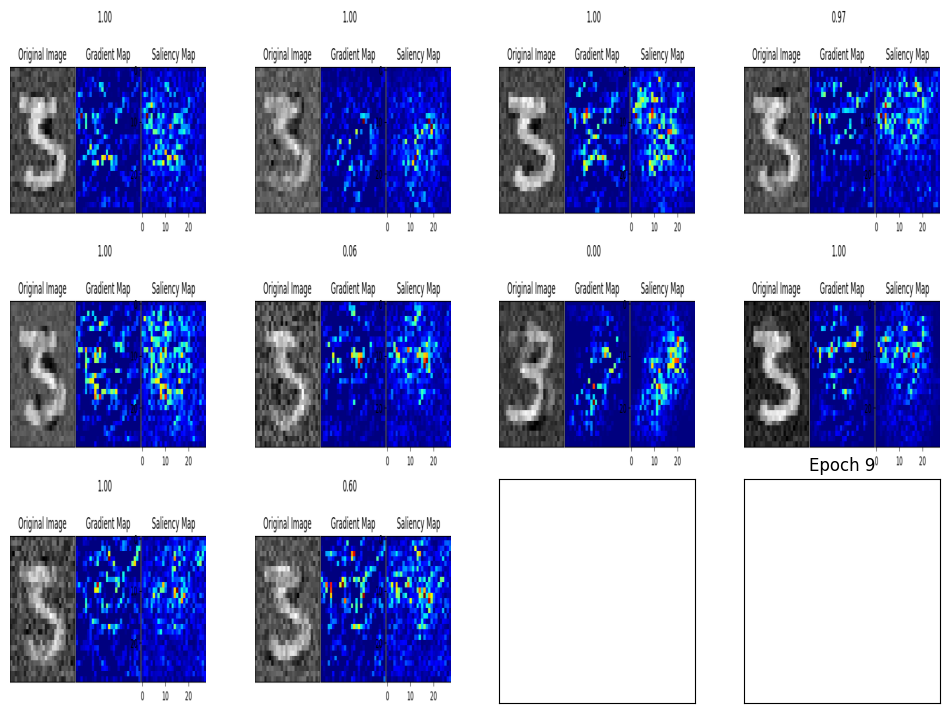

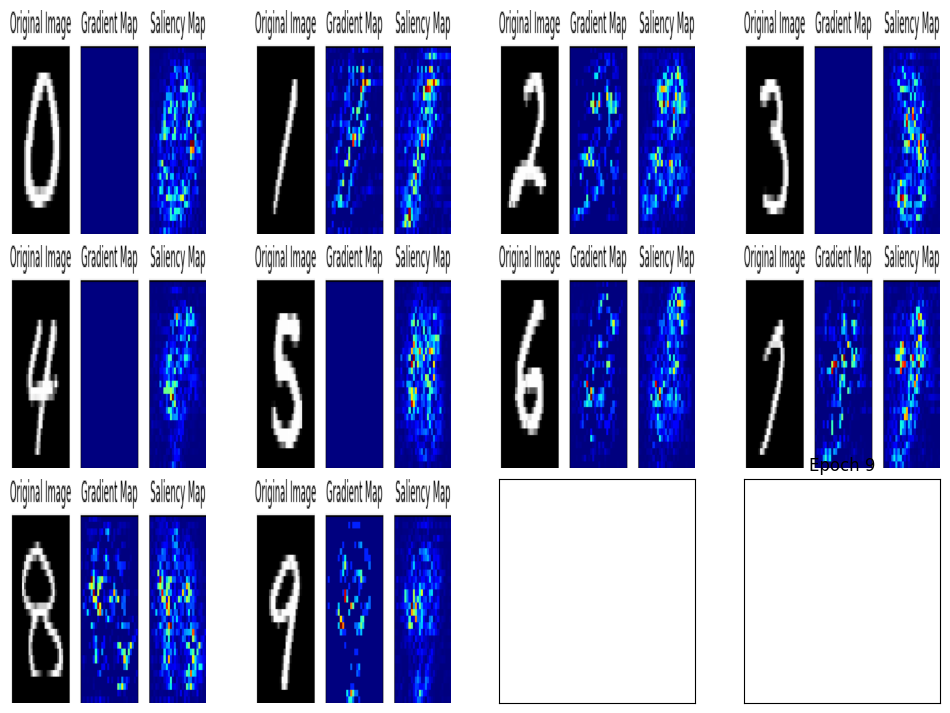

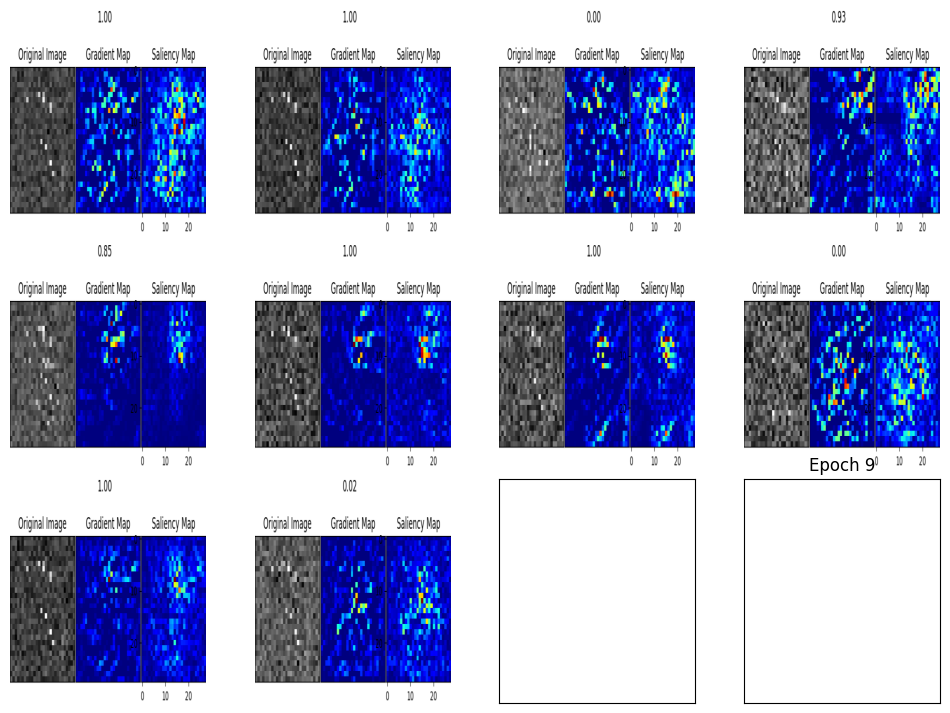

In [14]:
create_gif('APSO_different_3', 'APSO_different_3', duration=500)
create_gif('epochs', 'epochs', duration=500)
create_gif('APSO_sparse_3', 'APSO_sparse_3', duration=500)

In [15]:
# import umap and train it on the a;l data in valid_data
import umap
import numpy as np
import matplotlib.pyplot as plt

# Get the data from valid_data and convert it to a NumPy array
data = np.vstack([image for images in valid_data.values() for image in images])
labels = np.repeat(list(valid_data.keys()), [len(images) for images in valid_data.values()])

# Create the UMAP object with a random seed for reproducibility
reducer = umap.UMAP(random_state=42)

# Fit the UMAP model to the data
embedding = reducer.fit_transform(data.reshape(len(data), 28*28))
initialPoints = torch.tensor(valid_data[3]).to(device)

# Run simulations using the runSimulations function
APSO = runSimulations(initialPoints, "sparse_3", model, 50)


/home/jamilg/anaconda3/envs/AO/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jamilg/anaconda3/envs/AO/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jamilg/anaconda3/envs/AO/lib/python3.10/site-packages/umap/distances.py:

In [16]:
# Create a directory for saving UMAP visualization images
os.makedirs('APSO_sparse_3_umap', exist_ok=True)
images = []
for i in range(len(APSO.swarm[0].history)):
    print(i)
    particles_pos = []
    for particle in APSO.swarm:
        particles_pos.append(particle.history[i])
    particles_pos = torch.stack(particles_pos)
    particles_pos = particles_pos.reshape(len(particles_pos), 28*28)

    # Get the UMAP embedding of the particles
    particles_embedding = reducer.transform(particles_pos.cpu().numpy())

    # Plot the UMAP embedding based on the labels
    plt.figure(figsize=(10, 10))
    for j in range(10):
        plt.scatter(embedding[labels == j, 0], embedding[labels == j, 1], s=5)
    plt.scatter(particles_embedding[:, 0], particles_embedding[:, 1], c='black', s=5)

    # Add labels and legend for 10 classes and particles
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Particles'])
    plt.title(f"Epoch {i}")

    # Save the UMAP visualization as an image
    plt.savefig(f'APSO_sparse_3_umap/{i}.png')
    plt.close()
    images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))

# Save the UMAP visualization as a GIF
imageio.mimsave('APSO_sparse_3_umap.gif', images, duration=500)

0


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


1


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


2


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


3


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


4


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


5


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


6


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


7


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


8


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


9


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


10


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


11


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


12


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


13


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


14


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


15


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


16


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


17


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


18


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


19


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


20


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


21


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


22


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


23


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


24


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


25


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


26


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


27


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


28


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


29


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


30


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


31


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


32


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


33


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


34


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


35


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


36


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


37


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


38


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


39


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


40


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


41


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


42


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


43


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


44


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


45


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


46


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


47


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


48


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


49


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


50


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


51


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


52


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


53


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


54


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


55


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


56


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


57


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


58


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


59


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


60


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


61


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


62


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


63


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


64


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


65


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


66


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


67


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


68


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


69


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


70


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


71


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


72


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


73


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


74


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


75


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


76


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


77


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


78


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


79


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


80


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


81


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


82


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


83


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


84


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


85


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


86


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


87


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


88


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


89


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


90


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


91


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


92


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


93


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


94


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


95


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


96


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


97


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


98


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


99


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))


100


/tmp/ipykernel_33883/2728173957.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'APSO_sparse_3_umap/{i}.png'))
